In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.sqrt(-1+0j)

## The following doesn't work since the input is of type float 
## which corresponds to a real value (not complex)
# np.sqrt(-1)

1j

In [3]:
def get_k(energy, constant_potential):
    """Return k == \sqrt{2m(E-V0)}/hbar for constant potential V0"""
    m, hbar = 1.0, 1.0  # using atomic unit
    E, V0 = energy, constant_potential  # aliasing for convenience
    k = np.sqrt(2*m*(E-V0)+0j) / hbar
    return k

def f(x, energy, constant_potential):
    """Return one solution of time-independent schrödinger equation for a given constant potential
    
    Corresponding k == \sqrt{2m(E-V0)}/hbar is the second return value.
    
    The solution is returned in a form of exponential.
    Thus, the other linearly independent solution can be obtained by inverting its solution
    Namely, letting `f1` the solution obtained by this method, 
    the other linearly independet solution is `1 / f1`
    """
    k = get_k(energy, constant_potential)
    f_val = np.exp(1.0j * k * x)
    return f_val, k

In [4]:
from numbers import Integral

def sol(x, energy, constant_potential, sol_index, diff_number):
    for int_args in [sol_index, diff_number]: assert isinstance(int_args, Integral)
    assert sol_index in [1, 2]
    # [180423 NOTE] `diff_number` can also be negative, representing integral
    # assert diff_number >= 0
    
    f_val, k = f(x, energy, constant_potential)
    diff_factor = None
    if sol_index == 1: diff_factor = 1.0j * k
    elif sol_index == 2:
        f_val **= -1
        diff_factor = - 1.0j * k
    else: raise Exception("Unexpected solution index: {0}".format(sol_index))
    f_val *= diff_factor ** diff_number
    return f_val

In [5]:
from numbers import Number

def W(x, energy, constant_potential):
    """Calculate Wronskian matrix for two solutions under given constant potential"""
    assert isinstance(x, Number)
    wronskian = np.empty((2,2), dtype=complex)
    for idx0, diff_number in enumerate([0,1]):
        for idx1, sol_index in enumerate([1,2]):
            wronskian[idx0, idx1] = sol(x, energy, constant_potential, sol_index, diff_number)
    return wronskian

### Test plotting

In [6]:
x = np.linspace(-2,2,100)

In [7]:
f_val, k = f(x, 0.6, 1.0)
f_val_sol = sol(x, 0.6, 1.0, 1, 0)

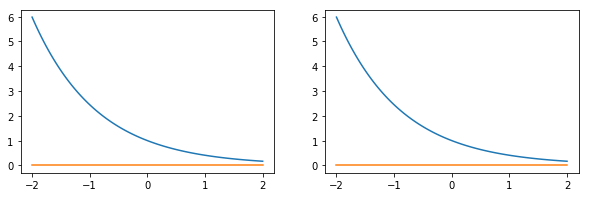

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
axes[0].plot(x,f_val.real)
axes[0].plot(x,f_val.imag)
axes[1].plot(x,f_val_sol.real)
axes[1].plot(x,f_val_sol.imag)

# Step potential

### Set free variables (coefficients)

In [9]:
A2, B2 = 1, 0

### Set system variables

In [10]:
E, V0 = 1.5, 1.0  # total energy / constant potential energy

In [11]:
x1 = 3  # boundary coordinate

### Solve for coefficients

In [12]:
W1 = W(x1, E, 0.0)
W2 = W(x1, E, V0)

In [13]:
b = W2 @ [A2, B2]

In [14]:
A1, B1 = np.linalg.solve(W1, b)

In [15]:
x_arr = np.linspace(-15,15,1000)
x_I0 = x_arr[x_arr < x1]
x_I1 = x_arr[x_arr >= x1]

In [16]:
psi_1 = A1 * sol(x_I0, E, 0.0, 1, 0) + B1 * sol(x_I0, E, 0.0, 2, 0)
psi_2 = A2 * sol(x_I1, E, V0, 1, 0) + B2 * sol(x_I1, E, V0, 2, 0)

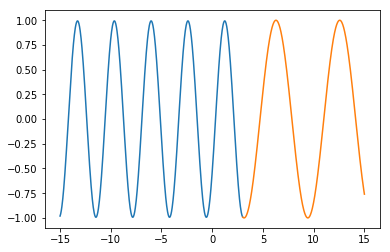

In [17]:
fig, ax = plt.subplots()
ax.plot(x_I0, psi_1.real)
ax.plot(x_I1, psi_2.real)

In [18]:
#fig.savefig('step-pot-using-wronskian-A2-1-B2-0.png')

# [ Finite Barrier ]

## Generating an image for finite barrier potential

### Configure system parameters

In [19]:
N_intervals = 3
x_min = '-infinity'
x_max = '+infinity'
num_boundary_coords = N_intervals - 1
if x_min != '-infinity': num_boundary_coords += 1
if x_max != '+infinity': num_boundary_coords += 1
boundary_coords = np.array([1,1.5])

V0_array = np.array([0, 2, 0], dtype=float)

assert V0_array.size == N_intervals
assert boundary_coords.size == num_boundary_coords

x_lim = (-25,25)
for x_i in boundary_coords: assert (x_i > x_lim[0]) and (x_i < x_lim[1])

### Configure plotting parameters

##### data

In [20]:
coords_in_fig = np.empty((N_intervals+1,), dtype=float)
coords_in_fig[0], coords_in_fig[-1] = x_lim
if num_boundary_coords == N_intervals - 1:
    coords_in_fig[1:-1] = boundary_coords
else: raise NotImplementedError()
    
assert coords_in_fig.size - 1 == V0_array.size

##### appearence

In [21]:
potential_line_color = (1,0,0,0.5)
potential_dash_kwargs = {'color':(1,0,0,0.5), 'linestyle':':'}

### Draw

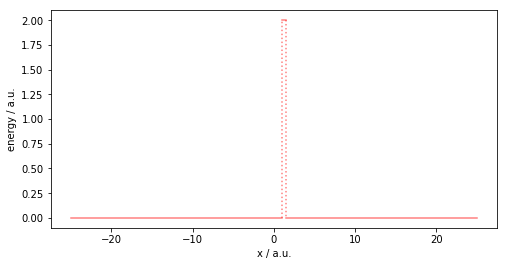

In [22]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set_xlabel('x / a.u.')
ax.set_ylabel('energy / a.u.')

for idx in range(coords_in_fig.size - 1):
    x_data = [coords_in_fig[idx], coords_in_fig[idx+1]]
    y_data = [V0_array[idx], V0_array[idx]]
    ax.plot(x_data, y_data, color=potential_line_color)
    
for idx in range(coords_in_fig.size - 2):
    x_data = [coords_in_fig[idx+1]] * 2
    y_data = [V0_array[idx], V0_array[idx+1]]
    ax.plot(x_data, y_data, **potential_dash_kwargs)

# Solve system of linear equations for unknown coefficients

### Set energy

In [23]:
E = 0.1

### Set free coefficients

In [24]:
coef_array = np.empty((N_intervals,2), dtype=complex)
coef_array[0,:] = [1.5, 0]

### Solve equations using matrix

In [25]:
boundary_coords

array([1. , 1.5])

In [26]:
for idx in range(N_intervals - 1):
    A = W(boundary_coords[idx], E, V0_array[idx+1])
    b = W(boundary_coords[idx], E, V0_array[idx]) @ coef_array[idx,:]
    coef_array[idx+1,:] = np.linalg.solve(A,b)

In [27]:
coef_array

array([[ 1.5       +0.j        ,  0.        +0.j        ],
       [ 5.27270735+1.18849624j,  0.08568011+0.06826155j],
       [ 1.43366574-3.93577235j, -3.51691079+1.7108594j ]])

### Reconstruct solution

In [28]:
coords_in_fig

array([-25. ,   1. ,   1.5,  25. ])

In [29]:
x_arr = np.linspace(*x_lim,1000)

In [30]:
def linear_sum_sol_in_same_interval(x, energy, constant_potential, coefs, diff_number=0):
    assert len(coefs) == 2
    summed_sol = 0.0
    for idx, sol_index in enumerate(range(1,len(coefs)+1)):
        summed_sol += coefs[idx] * sol(x, energy, constant_potential, sol_index, diff_number)
    return summed_sol

In [31]:
from numbers import Integral, Number
def global_sol(x, energy, V0_array, boundary_coords, coef_array, diff_number=0):
    assert isinstance(diff_number, Integral)
    assert isinstance(energy, Number)
    assert isinstance(x, np.ndarray)
    assert len(V0_array) == len(coef_array)
    N_intervals = len(V0_array)
    global_sol_array = np.empty_like(x, dtype=complex)
    for idx in range(N_intervals):
        x_interval_mask = None
        if idx == 0: x_interval_mask = x < boundary_coords[idx]
        elif idx == N_intervals - 1: x_interval_mask = x >= boundary_coords[N_intervals - 1 - 1]
        else: x_interval_mask = (x >= boundary_coords[idx-1]) & (x < boundary_coords[idx])
        x_interval = x[x_interval_mask]
        global_sol_array[x_interval_mask] = linear_sum_sol_in_same_interval(
            x_interval, energy, V0_array[idx], coef_array[idx,:], diff_number)
    return global_sol_array

In [32]:
sol_array = global_sol(x_arr, E, V0_array, boundary_coords, coef_array)

(-2, 3)

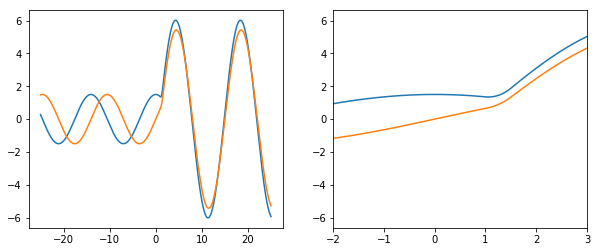

In [33]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(x_arr, sol_array.real)
axes[0].plot(x_arr, sol_array.imag)

axes[1].plot(x_arr, sol_array.real)
axes[1].plot(x_arr, sol_array.imag)
axes[1].set_xlim(-2,3)

In [34]:
#fig.savefig('finite-potential-wall-example.png')